#Preliminary settings

In [ ]:
# import
import os
import shutil
from google.colab import drive
import pandas as pd
from tqdm import tqdm

import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, save_model, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization, Flatten, Dense, GlobalAveragePooling2D, Add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras import applications
from keras import optimizers

from keras.utils.vis_utils import plot_model

In [ ]:
drive.mount('/content/drive')
model_dir = '/content/drive/MyDrive/Didattica/Exercise08_learning_strategies/'

Mounted at /content/drive


#The CUB-200 2011 dataset
![CUB-200-2011](https://production-media.paperswithcode.com/datasets/CUB-200-2011-0000000109-6e01ce73_vMleyYb.jpeg)

The Caltech-UCSD Birds-200-2011 (CUB-200-2011) dataset is the most widely-used dataset for fine-grained visual categorization task. It contains 11,788 images of 200 subcategories belonging to birds, 5,994 for training and 5,794 for testing. Each image has detailed annotations: 1 subcategory label, 15 part locations, 312 binary attributes and 1 bounding box. The textual information comes from Reed et al.. They expand the CUB-200-2011 dataset by collecting fine-grained natural language descriptions. Ten single-sentence descriptions are collected for each image. The natural language descriptions are collected through the Amazon Mechanical Turk (AMT) platform, and are required at least 10 words, without any information of subcategories and actions.

##Download and unzip

In [ ]:
!wget "https://data.deepai.org/CUB200(2011).zip"
!unzip "CUB200(2011).zip"
!tar -xzvf CUB_200_2011.tgz
!rm "CUB200(2011).zip" CUB_200_2011.tgz
!mv segmentations.tgz CUB_200_2011/
!mv attributes.txt CUB_200_2011/attributes/

##Dataset description files

In [ ]:
!head CUB_200_2011/classes.txt

1 001.Black_footed_Albatross
2 002.Laysan_Albatross
3 003.Sooty_Albatross
4 004.Groove_billed_Ani
5 005.Crested_Auklet
6 006.Least_Auklet
7 007.Parakeet_Auklet
8 008.Rhinoceros_Auklet
9 009.Brewer_Blackbird
10 010.Red_winged_Blackbird


In [ ]:
!head CUB_200_2011/train_test_split.txt

1 0
2 1
3 0
4 1
5 1
6 0
7 1
8 1
9 1
10 0


In [ ]:
!head CUB_200_2011/images.txt

1 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
2 001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg
3 001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg
4 001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg
5 001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg
6 001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg
7 001.Black_footed_Albatross/Black_Footed_Albatross_0031_100.jpg
8 001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg
9 001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg
10 001.Black_footed_Albatross/Black_Footed_Albatross_0025_796057.jpg


##Join dataset information

In [ ]:
files = pd.read_csv('CUB_200_2011/images.txt',           names=['index', 'path'],   sep=' ', header=None, index_col=0)
split = pd.read_csv('CUB_200_2011/train_test_split.txt', names=['index', 'subset'], sep=' ', header=None, index_col=0)

dataset = files.join(split, on='index')
dataset

,path,subset
index,,
1,001.Black_footed_Albatross/Black_Footed_Albatr...,0
2,001.Black_footed_Albatross/Black_Footed_Albatr...,1
3,001.Black_footed_Albatross/Black_Footed_Albatr...,0
4,001.Black_footed_Albatross/Black_Footed_Albatr...,1
5,001.Black_footed_Albatross/Black_Footed_Albatr...,1
...,...,...
11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,1
11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,0
11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,0


##Show samples

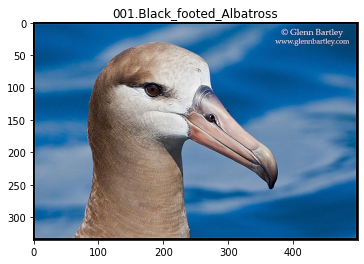

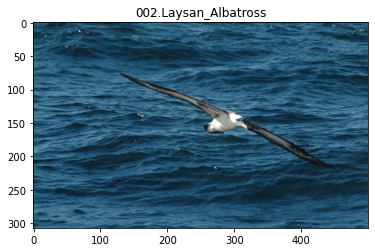

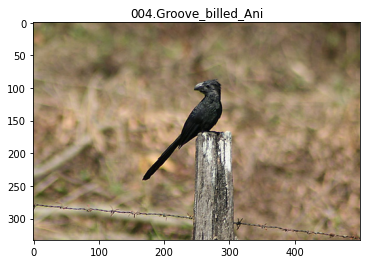

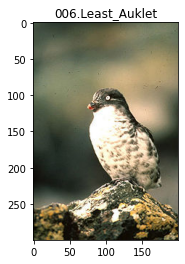

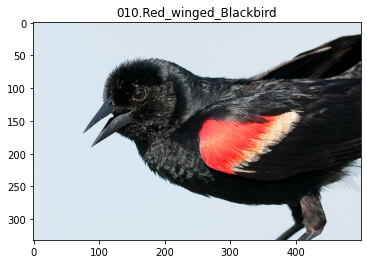

In [ ]:
indices = [0, 100, 200, 300, 500]

for index in indices:
  plt.figure()
  plt.imshow(PIL.Image.open(os.path.join('CUB_200_2011', 'images', dataset['path'].iloc[index])))
  plt.title(dataset['path'].iloc[index].split('/')[0])

##Organize

In [ ]:
val_perc = .2

np.random.seed(0)
shutil.rmtree('dataset', ignore_errors=True)
counter = {'train': 0, 'val': 0, 'test': 0}
for index, (path, subset) in tqdm(dataset.iterrows(), total=len(dataset), desc='Copying files'):
  in_path = os.path.join('CUB_200_2011', 'images', path)

  if subset:
    if np.random.rand() < val_perc:
      subset_dir = 'val'
    else:
      subset_dir = 'train'
  else:
    subset_dir = 'test'
  out_path = os.path.join('dataset', subset_dir, path)
  counter[subset_dir] += 1
  
  os.makedirs(os.path.dirname(out_path), exist_ok=True)
  shutil.copyfile(in_path, out_path)

counter
num_classes = 200



Copying files: 100%|██████████| 11788/11788 [00:06<00:00, 1794.44it/s]


#Preprocessing

In [ ]:
aug = ImageDataGenerator(
    rescale=1. / 255,     # rescale
    shear_range=0.2,      # on-the-fly data augmentation
    zoom_range=0.2,       # on-the-fly data augmentation
    horizontal_flip=True) # on-the-fly data augmentation

no_aug = ImageDataGenerator(rescale=1. / 255)


target_size = (224, 224)  # resize dimensions of our images
batch_size = 64           # number of images in a batch

print('Training set generator:')
train_generator = aug.flow_from_directory('dataset/train',
    target_size=target_size, batch_size=batch_size, class_mode='categorical')

print('Validation set generator:')
val_generator = no_aug.flow_from_directory('dataset/val',
    target_size=target_size, batch_size=batch_size, class_mode='categorical')

print('Test set generator:')
test_generator = no_aug.flow_from_directory('dataset/test',
    target_size=target_size, batch_size=batch_size, class_mode='categorical')

Training set generator:
Found 4778 images belonging to 200 classes.
Validation set generator:
Found 1216 images belonging to 200 classes.
Test set generator:
Found 5794 images belonging to 200 classes.


#Network
ResNet50 with pre-trained weights

In [ ]:
num_classes=200

In [ ]:
from keras.applications.resnet import ResNet50
model_name = 'resnet50'

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(units=num_classes, activation='softmax')(x)
model = Model(base_model.input, predictions)

#Training

In [ ]:
train_after_layer = 25

for layer in model.layers[:train_after_layer]:
    layer.trainable = False
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.gradient_descent_v2.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'],
              )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Didattica/ML/Exercises/Exercise08_learning_strategies/logs

In [ ]:
epochs_fine = 100

model.fit_generator(
    train_generator,
    steps_per_epoch=counter['train'] // batch_size,
    validation_data=val_generator,
    validation_steps=counter['val'] // batch_size,
    epochs=epochs_fine,
    callbacks=[
            ModelCheckpoint(model_dir + 'models/' + model_name + '_finetuned', monitor='val_loss', save_best_only=True),
            TensorBoard(model_dir + 'logs/' + model_name + '_finetuned'),
            ])

In [ ]:
model = load_model(model_dir + 'models/resnet50_finetuned')

In [ ]:
model.evaluate(test_generator, steps=counter['test'] // batch_size)

#Exercise
Try to implement the following learning strategies:


*   Skip connections
*   Greedy supervised pre-training
*   Auxiliary heads



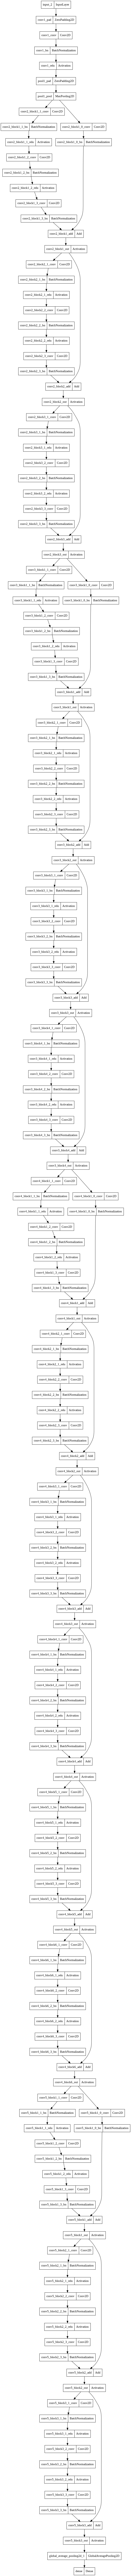

In [ ]:
plot_model(model)

#Skip connection block

In [ ]:
def add_skip_block(block_input_node, num_features, feature_reduction_factor=1, kernel_size=3):
  x = Conv2D(num_features // feature_reduction_factor,
             kernel_size, padding='same', activation='relu')(block_input_node)
             
  x = BatchNormalization()(x)

  x = Conv2D(num_features, kernel_size, padding='same', activation='relu')(x)

  return Add()([x, block_input_node])

def add_head_block(block_input_node, name=None):
  x = GlobalAveragePooling2D()(block_input_node)
  return Dense(units=num_classes, activation='softmax', name=name)(x)
  

In [ ]:
model.layers[selected_layer].output.shape

TensorShape([None, None, None, 64])

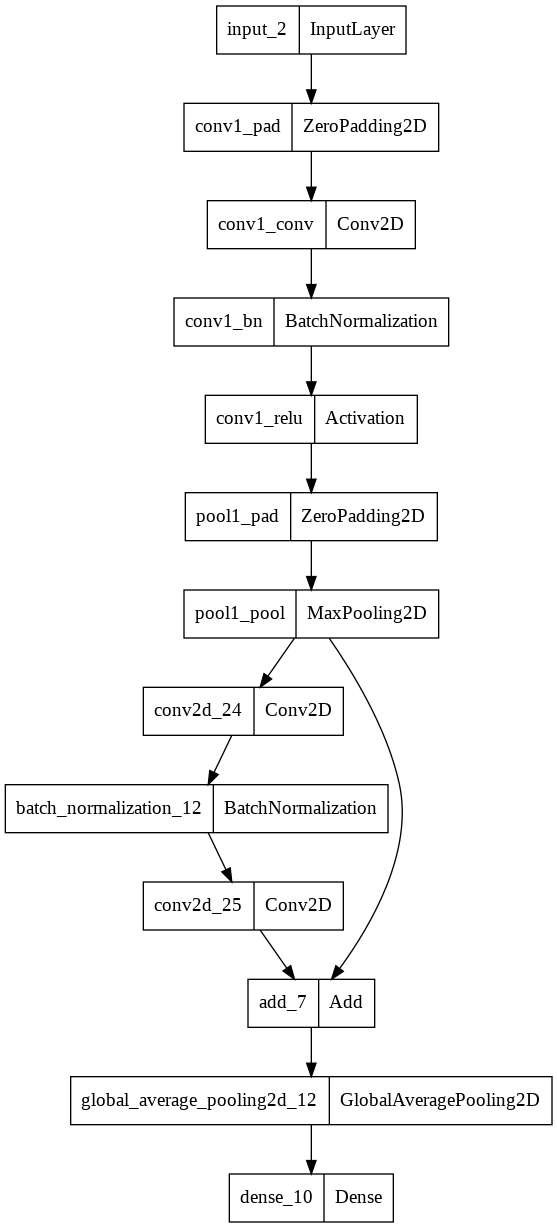

In [ ]:
selected_layer = 6

skip_node = add_skip_block(
    block_input_node=model.layers[selected_layer].output,
    num_features=model.layers[selected_layer].output.shape[-1],
    feature_reduction_factor=1,
    )

predictions = add_head_block(block_input_node=skip_node)
model_skip = Model(model.input, predictions)
plot_model(model_skip, 'model_skip.png')

#Auxiliary heads

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


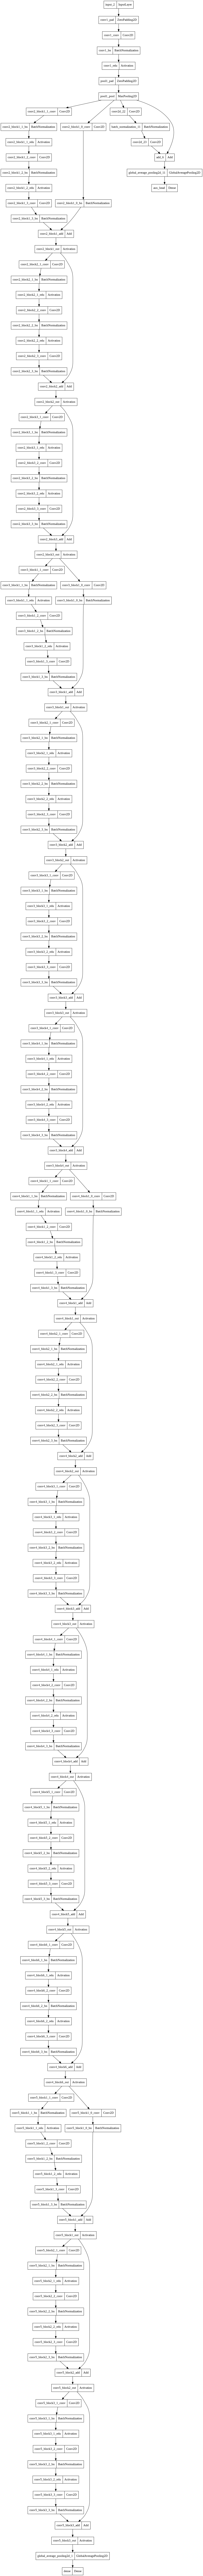

In [ ]:
selected_layer = 6

skip_node = add_skip_block(
    block_input_node=model.layers[selected_layer].output,
    num_features=model.layers[selected_layer].output.shape[-1],
    feature_reduction_factor=1,
    )

predictions = add_head_block(block_input_node=skip_node, name='aux_head')
model_aux = Model(model.input, [predictions, model.output])


model_aux.compile(
    loss={'dense':'categorical_crossentropy', 'aux_head':'categorical_crossentropy'},#['categorical_crossentropy', 'categorical_crossentropy'],
              optimizer=optimizers.gradient_descent_v2.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'],
              )

plot_model(model_aux, 'model_aux.png')

In [ ]:
def data_gen(gen):
  for X, y in gen:
    yield X, {'dense': y, 'aux_head': y}

In [ ]:
epochs = 10
model_aux.fit_generator(
    data_gen(train_generator),
    steps_per_epoch=counter['train'] // batch_size,
    validation_data=data_gen(val_generator),
    validation_steps=counter['val'] // batch_size,
    epochs=epochs,
    callbacks=[
            ModelCheckpoint(model_dir + 'models/' + model_name + '_aux', monitor='val_loss', save_best_only=True),
            TensorBoard(model_dir + 'logs/' + model_name + '_aux'),
            ])